##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

# Load Input Images and Poses

In [16]:
data = np.load('tiny_nerf_data.npz')
images = torch.from_numpy(data['images']).float().to(device)
poses = torch.from_numpy(data['poses']).float().to(device)
focal = float(data['focal'])
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

torch.Size([106, 100, 100, 3]) torch.Size([106, 4, 4]) 138.88887889922103


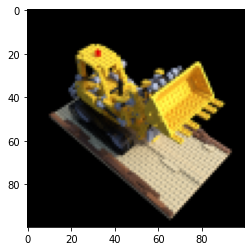

tensor([[-9.9990e-01,  4.1922e-03, -1.3346e-02, -5.3798e-02],
        [-1.3989e-02, -2.9966e-01,  9.5394e-01,  3.8455e+00],
        [-4.6566e-10,  9.5404e-01,  2.9969e-01,  1.2081e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')


In [17]:
testimg = testimg.cpu().numpy()
plt.imshow(testimg)
plt.show()
print(poses[0])

# Optimize NeRF

In [18]:
# Positional encoding function
def posenc(x, L_embed=6):
    rets = [x]
    for i in range(L_embed):
        for fn in [torch.sin, torch.cos]:
            rets.append(fn(2.**i * x))
    return torch.cat(rets, -1)

In [48]:
# NeRF model (reduced size)
class TinyNeRF(nn.Module):
    def __init__(self, D=4, W=128, input_ch=63, output_ch=4):
        super(TinyNeRF, self).__init__()
        self.net = nn.ModuleList([nn.Linear(input_ch, W)] + 
                                 [nn.Linear(W, W) if i != D-1 else nn.Linear(W, output_ch) for i in range(D)])
    
    def forward(self, x):
        h = x
        for i, l in enumerate(self.net):
            h = self.net[i](h)
            if i < len(self.net) - 1:
                h = nn.functional.relu(h)
        return h

# Ray generation function
def get_rays(H, W, focal, c2w):
    i, j = torch.meshgrid(torch.arange(W), torch.arange(H), indexing='xy')
    dirs = torch.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -torch.ones_like(i)], -1)
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3,:3], -1)
    rays_o = c2w[:3,-1].expand(rays_d.shape)
    return rays_o, rays_d

# Rendering function
def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False, chunk=1024):
    N_rays = rays_o.shape[0]
    
    t_vals = torch.linspace(0., 1., steps=N_samples)
    z_vals = near * (1.-t_vals) + far * t_vals
    z_vals = z_vals.expand([N_rays, N_samples])
    
    if rand:
        mids = .5 * (z_vals[...,1:] + z_vals[...,:-1])
        upper = torch.cat([mids, z_vals[...,-1:]], -1)
        lower = torch.cat([z_vals[...,:1], mids], -1)
        t_rand = torch.rand(z_vals.shape)
        z_vals = lower + (upper - lower) * t_rand
    
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    raw = []
    for i in range(0, pts.shape[0], chunk):
        pts_chunk = pts[i:i+chunk].reshape(-1, 3)
        encoded_chunk = posenc(pts_chunk, L_embed=10)
        raw_chunk = network_fn(encoded_chunk.to(device)).cpu()
        raw.append(raw_chunk.reshape(pts_chunk.shape[0], N_samples, 4))
    raw = torch.cat(raw, dim=0)
    
    sigma_a = nn.functional.relu(raw[...,3])
    rgb = torch.sigmoid(raw[...,:3])
    
    dists = z_vals[...,1:] - z_vals[...,:-1]
    dists = torch.cat([dists, torch.full_like(dists[...,:1], 1e10)], -1)
    alpha = 1.-torch.exp(-sigma_a * dists)
    weights = alpha * torch.cumprod(torch.cat([torch.ones_like(alpha[...,:1]), 1.-alpha + 1e-10], -1), -1)[..., :-1]
    
    rgb_map = torch.sum(weights[...,None] * rgb, -2)
    depth_map = torch.sum(weights * z_vals, -1)
    acc_map = torch.sum(weights, -1)
    
    return rgb_map, depth_map, acc_map

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

In [45]:
# Training loop
def train_nerf(images, poses, focal, N_iters=1000, N_samples=32, lr=5e-4, chunk=1024):
    model = TinyNeRF(input_ch=63, output_ch=4).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    psnrs = []
    iternums = []
    
    for i in tqdm(range(N_iters + 1)):
        img_i = np.random.randint(images.shape[0])
        target = images[img_i]
        pose = poses[img_i]
        rays_o, rays_d = get_rays(H, W, focal, pose)
        
        rays_o = rays_o.reshape(-1, 3)
        rays_d = rays_d.reshape(-1, 3)
        target = target.reshape(-1, 3)
        
        rgb, depth, acc = [], [], []
        for j in range(0, rays_o.shape[0], chunk):
            rgb_chunk, depth_chunk, acc_chunk = render_rays(model, 
                                                            rays_o[j:j+chunk], 
                                                            rays_d[j:j+chunk], 
                                                            near=2., far=6., 
                                                            N_samples=N_samples, 
                                                            rand=True,
                                                            chunk=chunk)
            rgb.append(rgb_chunk)
            depth.append(depth_chunk)
            acc.append(acc_chunk)
        
        rgb = torch.cat(rgb, 0)
        depth = torch.cat(depth, 0)
        acc = torch.cat(acc, 0)
        
        loss = torch.mean((rgb - target) ** 2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 25 == 0:
            with torch.no_grad():
                rays_o, rays_d = get_rays(H, W, focal, testpose)
                rays_o = rays_o.reshape(-1, 3)
                rays_d = rays_d.reshape(-1, 3)
                rgb, depth, acc = [], [], []
                for j in range(0, rays_o.shape[0], chunk):
                    rgb_chunk, depth_chunk, acc_chunk = render_rays(model, 
                                                                    rays_o[j:j+chunk], 
                                                                    rays_d[j:j+chunk], 
                                                                    near=2., far=6., 
                                                                    N_samples=N_samples,
                                                                    chunk=chunk)
                    rgb.append(rgb_chunk)
                    depth.append(depth_chunk)
                    acc.append(acc_chunk)
                
                rgb = torch.cat(rgb, 0).reshape(H, W, 3)
                depth = torch.cat(depth, 0).reshape(H, W)
                acc = torch.cat(acc, 0).reshape(H, W)
                
                loss = torch.mean((rgb - testimg) ** 2)
                psnr = -10. * torch.log10(loss)

            psnrs.append(psnr.item())
            iternums.append(i)

            plt.figure(figsize=(10,4))
            plt.subplot(121)
            plt.imshow(rgb.numpy())
            plt.title(f'Iteration: {i}')
            plt.subplot(122)
            plt.plot(iternums, psnrs)
            plt.title('PSNR')
            plt.show()
    
    return model, psnrs, iternums

In [47]:
# Run the training
model, psnrs, iternums = train_nerf(images, poses, focal, chunk=256, N_samples=16)

print('Training complete')

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 

# Interactive Visualization

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)